# Homework 05

## Due Tuesday, March 29th

In [1]:
from __future__ import print_function   # Python 2/3 compatability
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from __future__ import print_function   
import shapely.geometry
import shapely.ops
from scipy.interpolate import griddata
from scipy import spatial

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


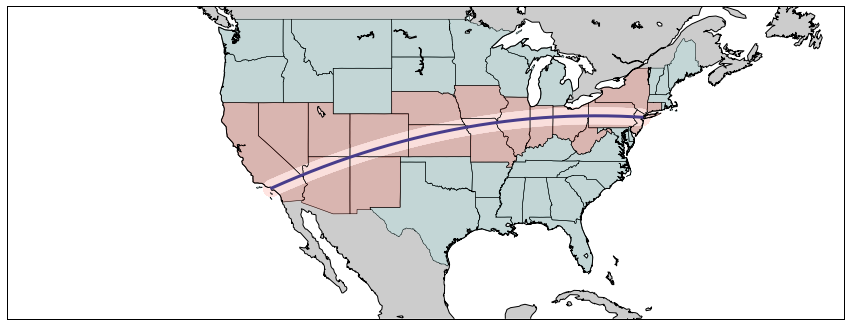

In [2]:
#Read in the shape file for the states
fig = plt.figure(figsize=(15,10))
from mpl_toolkits.basemap import Basemap
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('../python4geosciences-hw/materials/states_21basic/states', 'states')

#plot the map with the flight route from LAX to EWR
x,y = m.gcpoints(-118.4081, 33.9425, -74.1686, 40.6925, 1000)
m.fillcontinents()
m.drawcoastlines()
plt.plot(x,y,'darkslateblue',lw=3)

#Turn the line into a shape file, add a 100km buffer onto the line
line = []
for i in range(0,len(x)):
    line.append(shapely.geometry.Point(x[i], y[i]))

#create a buffer   
line_buffer = shapely.geometry.LineString(line).buffer(100000) 

# turn the states into polygons
polys = []
for state in m.states:
    polys.append(shapely.geometry.Polygon(state))
    
#Highlight states the plane would fly over
List_states= []
for i in range(len(polys)):
    if polys[i].intersects(line_buffer):
        color = 'salmon'
        List_states.append(m.states_info[i]['STATE_NAME'])
    else:
        color = 'paleturquoise'
    coords = shapely.ops.cascaded_union(polys[i].boundary).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)
    plt.fill(*line_buffer.boundary.xy, color='mistyrose',alpha=0.2)

### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


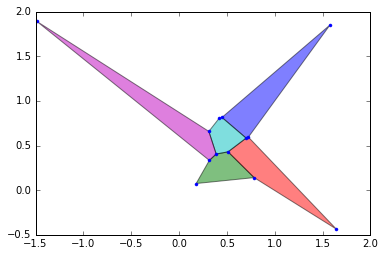

In [14]:
x = np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

voron = spatial.Voronoi(x)

for indices in voron.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram
    plt.fill(voron.vertices[indices, 0], voron.vertices[indices, 1], edgecolor='k', alpha=0.5)
plt.plot(voron.vertices[:,0], voron.vertices[:,1],'.b')

In [16]:
#Calculate area contained in finite regions
line = [shapely.geometry.LineString(voron.vertices[line])for line in voron.regions if -1 not in line]

poly = []
area=0
A01=0
A001=0
A0001=0

for poly in shapely.ops.polygonize(lines):
    polys.append(poly)
    area+=poly.area
    A01+=poly.buffer(-0.1).area
    A001+=poly.buffer(-0.01).area
    A0001+=poly.buffer(-0.001).area

print(area)
print(A01/area)
print(A001/area)
print(A0001/area)

#like what we did in class - create shape objects and buffer them

ValueError: LineStrings must have at least 2 coordinate tuples

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

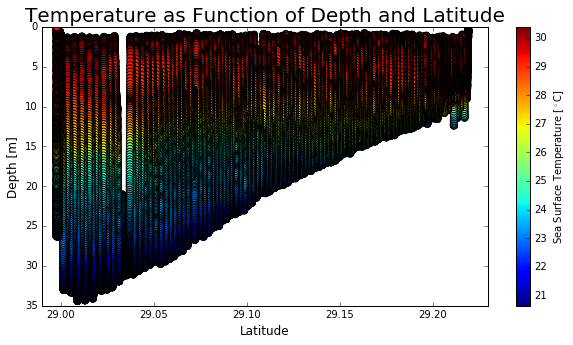

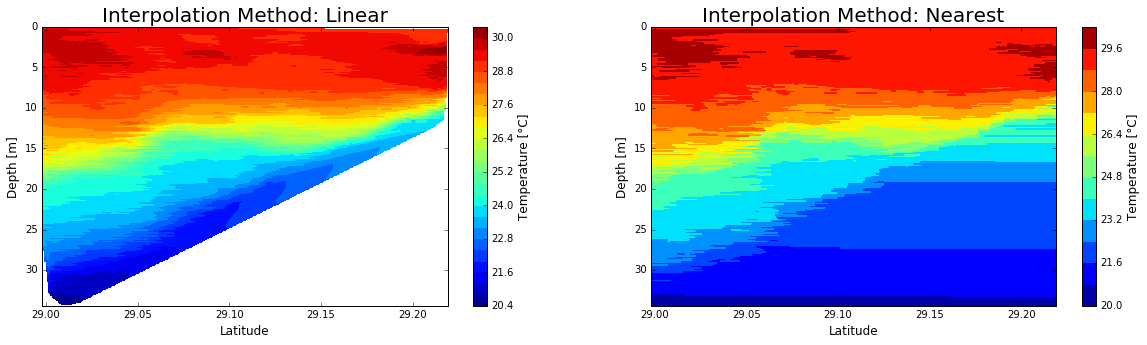

In [5]:
#read in file MS03_L15.txt
fname = np.genfromtxt('MS03_L15.txt', skip_header = 114)
lat = fname[:,0]
temp = fname[:,15]
depth = fname[:,2]

#scatter plot temperature as a function of depth and latitude
fig = plt.figure(figsize=(10, 5)) 
scatter = plt.scatter(lat, depth, s=50, c=temp)
plt.xlabel('Latitude', fontsize='12')
plt.xlim(28.99,29.23)
plt.ylabel('Depth [m]', fontsize='12')
plt.ylim(0,35)
plt.gca().invert_yaxis()
plt.title('Temperature as Function of Depth and Latitude',fontsize='20')
plt.colorbar().set_label(r'Sea Surface Temperature [$^\circ$C]')

#Interpolate temperature data uniform grid (make it structured)
xi, yi = np.linspace(lat.min(), lat.max(), 300), np.linspace(depth.min(), depth.max(), 300)
xi, yi = np.meshgrid(xi, yi)

zi = scipy.interpolate.griddata((lat, depth), temp, (xi, yi), method='linear')
zi2 = scipy.interpolate.griddata((lat, depth), temp, (xi, yi), method='nearest')

fig = plt.figure(figsize=(20,5))

#plot data linear method and nearest method
ax0 = fig.add_subplot(1,2,1) 
cp0 = ax0.contourf(xi,yi,zi, 30)
cb0 = plt.colorbar(cp0, ax=ax0)
# axes[0].gca().invert_yaxis()
ax0.set_ylabel('Depth [m]', size=12)
ax0.set_xlabel('Latitude', size=12)
cb0.set_label('Temperature [°C]', size=12)
ax0.set_title('Interpolation Method: Linear', size=20)
ax0.invert_yaxis()

ax1 = fig.add_subplot(1,2,2) 
cp1 = ax1.contourf(xi,yi,zi2, 15)
cb1 = plt.colorbar(cp1, ax=ax1)
ax1.set_ylabel('Depth [m]', size=12)
ax1.set_xlabel('Latitude', size=12)
cb1.set_label('Temperature [°C]', size=12)
ax1.set_title('Interpolation Method: Nearest', size=20)
ax1.invert_yaxis()

### 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

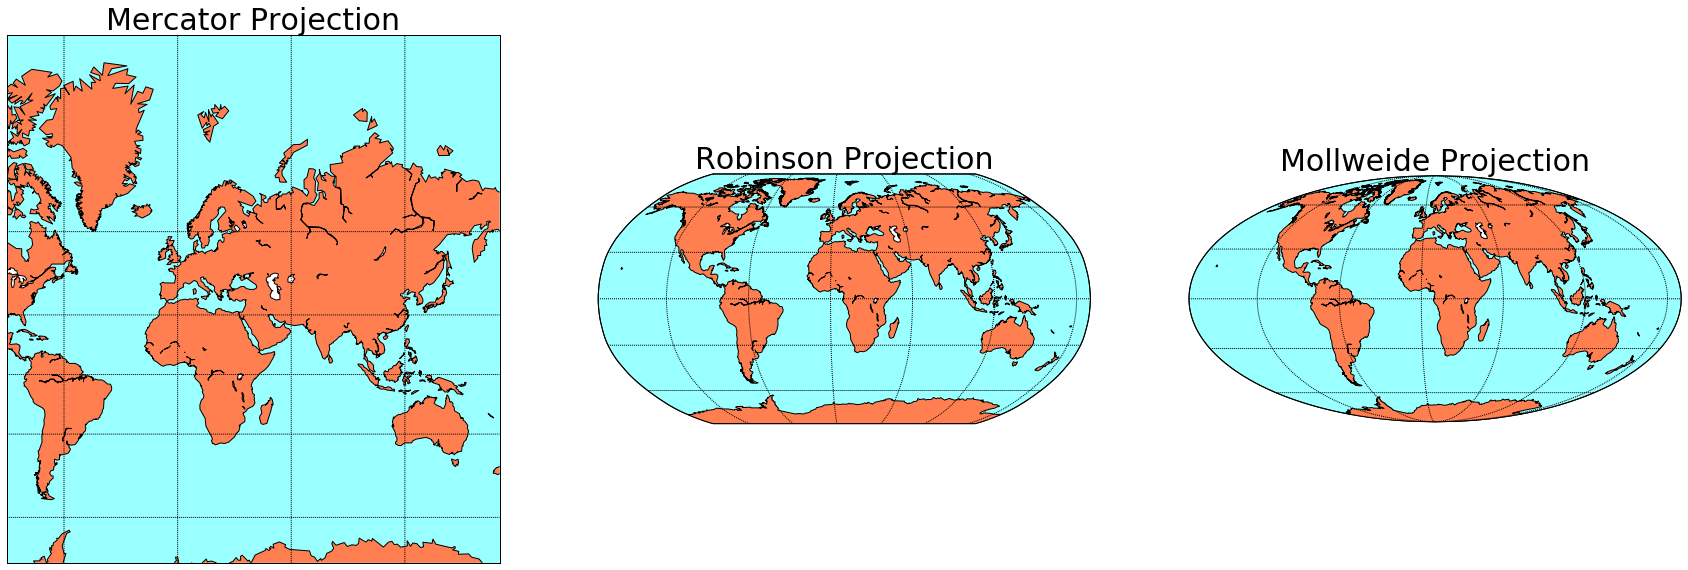

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(30,20))

# Mercador Projection
axes[0].set_title("Mercator Projection", size=30)
mer = Basemap(projection='merc',llcrnrlat=-70,urcrnrlat=85,\
            llcrnrlon=-90,urcrnrlon=170,lat_ts=20,resolution='c', ax=axes[0])
mer.fillcontinents(color='coral')
mer.drawcoastlines()
mer.drawmapboundary(fill_color='#99ffff')
mer.drawparallels(np.arange(-90.,91.,30.))
mer.drawmeridians(np.arange(-180.,181.,60.))

# Robinson Projection
axes[1].set_title("Robinson Projection", size=30)
rob = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, ax=axes[1])
rob.fillcontinents(color='coral')
rob.drawcoastlines()
rob.drawmapboundary(fill_color='#99ffff')
rob.drawparallels(np.arange(-90.,120.,30.))
rob.drawmeridians(np.arange(0.,420.,60.))

# Mollweide Projection
axes[2].set_title("Mollweide Projection", size=30)
moll = Basemap(projection='moll', lon_0 = 10, lat_0 = 50, ax=axes[2])
moll.fillcontinents(color='coral')
moll.drawcoastlines()
moll.drawmapboundary(fill_color='#99ffff')
moll.drawparallels(np.arange(-90.,120.,30.))
moll.drawmeridians(np.arange(0.,420.,60.))

plt.show()

In [7]:
#Areas using the mercador projection
mer.readshapefile('../python4geosciences-hw/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
MA=0
for state in mer.australia:
    MA+=shapely.geometry.Polygon(state).area
print(MA)

mer.readshapefile('../python4geosciences-hw/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
MG=0
for state in mer.greenland:
    MG+=shapely.geometry.Polygon(state).area
print(MG)

# Areas using Robinson Projection
rob.readshapefile('../python4geosciences-hw/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
RA=0
for state in rob.australia:
    RA+=shapely.geometry.Polygon(state).area
print(RA)

rob.readshapefile('../python4geosciences-hw/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
RG=0
for state in rob.greenland:
    RG+=shapely.geometry.Polygon(state).area
print(RG)

# Area using Mollweide Projection
moll.readshapefile('../python4geosciences-hw/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
MAA=0
for state in moll.australia:
    MAA+=shapely.geometry.Polygon(state).area
print(MAA)

moll.readshapefile('../python4geosciences-hw/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
MGG=0
for state in moll.greenland:
    MGG+=shapely.geometry.Polygon(state).area
print(MGG)

8501235310688.515
30789355371843.93
6791690519402.713
3423077331843.1274
7699609269222.03
2134440861608.1257
